# Export TF based Unet model trained with Sidewalk Dataset

This notebook shows how to train a [Unet model from TF official guide](https://www.tensorflow.org/tutorials/images/segmentation) on a Sidewalk dataset from [🤗 blog post](https://huggingface.co/blog/fine-tune-segformer).

## Imports

In [1]:
import tensorflow as tf
import numpy as np

## tf.data.Dataset from prepared TFRecords

In [9]:
GCS_PATH = "gs://sidewalks-tfx-hf/sidewalks-tfrecords"
BATCH_SIZE = 2
AUTO = tf.data.AUTOTUNE

### Get TFRecords and parse the input and label

In [15]:
def parse_tfr(proto):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string), 
        "label": tf.io.FixedLenFeature([], tf.string)
    }
    rec = tf.io.parse_single_example(proto, feature_description)

    image = tf.io.parse_tensor(rec["image"], tf.float32)
    label = tf.io.parse_tensor(rec["label"], tf.float32)

    return {"pixel_values": image, "labels": label}


def prepare_dataset(split="train", batch_size=BATCH_SIZE):
    if split not in ["train", "val"]:
        raise ValueError(
            "Invalid split provided. Supports splits are: `train` and `val`."
        )

    dataset = tf.data.TFRecordDataset(
        [filename for filename in tf.io.gfile.glob(f"{GCS_PATH}/{split}-*")],
        num_parallel_reads=AUTO,
    ).map(parse_tfr, num_parallel_calls=AUTO)

    if split == "train":
        dataset = dataset.shuffle(batch_size * 2)

    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(AUTO)
    return dataset

### Create tf.data.Dataset for training and validation dataset

In [16]:
train_dataset = prepare_dataset()
val_dataset = prepare_dataset(split="val")

In [12]:
batch = next(iter(train_dataset))
batch[0].shape, batch[1].shape

(TensorShape([2, 512, 512, 3]), TensorShape([2, 512, 512]))

### preprocessing

In [19]:
def preprocess(example_batch):
    images = example_batch["pixel_values"]
    images = tf.transpose(images, perm=[0, 1, 2, 3]) # (batch_size, height, width, num_channels)
    labels = tf.expand_dims(example_batch["labels"], -1) # Adds extra dimension, otherwise tf.image.resize won't work.
    labels = tf.transpose(labels, perm=[0, 1, 2, 3]) # So, that TF can evaluation the shapes.

    images = tf.image.resize(images, (128, 128))
    labels = tf.image.resize(labels, (128, 128))

    # images = tf.transpose(images, perm=[0, 3, 1, 2]) # (batch_size, num_channels, height, width)
    labels = tf.squeeze(labels, -1)
    
    return images, labels

In [20]:
train_dataset = train_dataset.map(preprocess)
val_dataset = val_dataset.map(preprocess)

### Display a sample image

In [21]:
# Investigate a single batch.
batch = next(iter(train_dataset))
batch[0].shape, batch[1].shape

(TensorShape([2, 128, 128, 3]), TensorShape([2, 128, 128]))

In [22]:
def sidewalk_palette():
    """Sidewalk palette that maps each class to RGB values."""
    return [
        [0, 0, 0],
        [216, 82, 24],
        [255, 255, 0],
        [125, 46, 141],
        [118, 171, 47],
        [161, 19, 46],
        [255, 0, 0],
        [0, 128, 128],
        [190, 190, 0],
        [0, 255, 0],
        [0, 0, 255],
        [170, 0, 255],
        [84, 84, 0],
        [84, 170, 0],
        [84, 255, 0],
        [170, 84, 0],
        [170, 170, 0],
        [170, 255, 0],
        [255, 84, 0],
        [255, 170, 0],
        [255, 255, 0],
        [33, 138, 200],
        [0, 170, 127],
        [0, 255, 127],
        [84, 0, 127],
        [84, 84, 127],
        [84, 170, 127],
        [84, 255, 127],
        [170, 0, 127],
        [170, 84, 127],
        [170, 170, 127],
        [170, 255, 127],
        [255, 0, 127],
        [255, 84, 127],
        [255, 170, 127],
    ]

In [23]:
def get_seg_overlay(image, seg):
    # image = tf.transpose(image, [1, 2, 0])
    color_seg = np.zeros(
        (seg.shape[0], seg.shape[1], 3), dtype=np.uint8
    )  # height, width, 3
    palette = np.array(sidewalk_palette())
    for label, color in enumerate(palette):
        color_seg[seg == label, :] = color

    # Show image + mask
    img = np.array(image) * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    return img

In [24]:
gt_img = get_seg_overlay(
    batch[0][0], 
    np.array(batch[1][0])
)

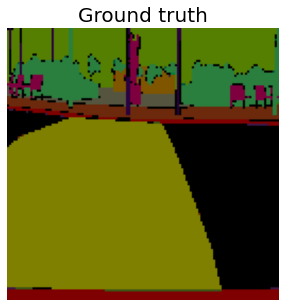

In [25]:
import matplotlib.pyplot as plt

f, axs = plt.subplots(1, 1)
f.set_figheight(5)
f.set_figwidth(10)

axs.set_title("Ground truth", {"fontsize": 20})
axs.imshow(gt_img)
axs.axis("off")

plt.show()

## Modeling

In [26]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Instance Normalization Layer (https://arxiv.org/abs/1607.08022)."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

In [27]:
def upsample(filters, size, norm_type='batchnorm', apply_dropout=False):
  """Upsamples an input.
  Conv2DTranspose => Batchnorm => Dropout => Relu
  Args:
    filters: number of filters
    size: filter size
    norm_type: Normalization type; either 'batchnorm' or 'instancenorm'.
    apply_dropout: If True, adds the dropout layer
  Returns:
    Upsample Sequential Model
  """

  initializer = tf.random_normal_initializer(0., 0.02)

  result = tf.keras.Sequential()
  result.add(
      tf.keras.layers.Conv2DTranspose(filters, size, strides=2,
                                      padding='same',
                                      kernel_initializer=initializer,
                                      use_bias=False))

  if norm_type.lower() == 'batchnorm':
    result.add(tf.keras.layers.BatchNormalization())
  elif norm_type.lower() == 'instancenorm':
    result.add(InstanceNormalization())

  if apply_dropout:
    result.add(tf.keras.layers.Dropout(0.5))

  result.add(tf.keras.layers.ReLU())

  return result

In [28]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[128, 128, 3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

9420800/9406464 [==============================] - 0s 0us/step


In [29]:
up_stack = [
    upsample(512, 3),  # 4x4 -> 8x8
    upsample(256, 3),  # 8x8 -> 16x16
    upsample(128, 3),  # 16x16 -> 32x32
    upsample(64, 3),   # 32x32 -> 64x64
]

In [30]:
def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[128, 128, 3], name="pixel_values")

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same',
      name="labels")  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

In [31]:
OUTPUT_CLASSES = len(sidewalk_palette())

model = unet_model(output_channels=OUTPUT_CLASSES)
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 pixel_values (InputLayer)      [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model (Functional)             [(None, 64, 64, 96)  1841984     ['pixel_values[0][0]']           
                                , (None, 32, 32, 14                                               
                                4),                                                               
                                 (None, 16, 16, 192                                               
                                ),                                                          

### Training

In [ ]:
EPOCHS = 5

model_history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=EPOCHS
)

### Display predictions

In [34]:
test_batch = next(iter(val_dataset))

In [35]:
pred_mask = model.predict(test_batch[0])

In [36]:
pred_seg = tf.math.argmax(pred_mask[0], axis=-1)

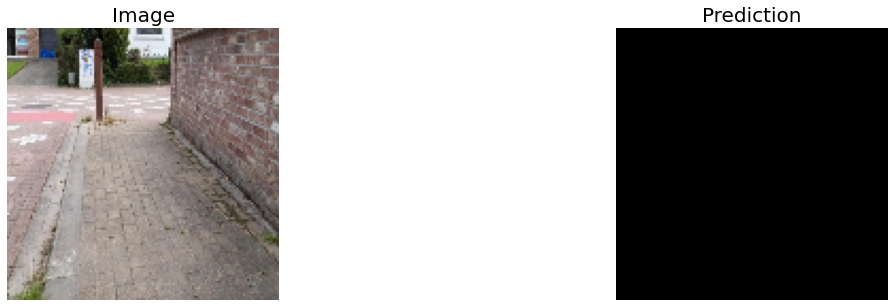

In [37]:
import matplotlib.pyplot as plt

seg_im = get_seg_overlay(test_batch[0][0], pred_seg)

f, axis = plt.subplots(1, 2)
f.set_figheight(5)
f.set_figwidth(20)

axis[0].set_title("Image", {"fontsize": 20})
axis[1].set_title("Prediction", {"fontsize": 20})
axis[0].axis("off")
axis[1].axis("off")

axis[0].imshow(test_batch[0][0])
axis[1].imshow(seg_im)

## Save/Exporting trained model

In [38]:
_IMAGE_SHAPE = (128, 128)
_CONCRETE_INPUT = "pixel_values"

def _serving_preprocess(string_input):
    decoded_input = tf.io.decode_base64(string_input)
    decoded = tf.io.decode_jpeg(decoded_input, channels=3)
    decoded = decoded / 255
    resized = tf.image.resize(decoded, size=_IMAGE_SHAPE)
    return resized

@tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
def _serving_preprocess_fn(string_input):
    decoded_images = tf.map_fn(
        _serving_preprocess, string_input, dtype=tf.float32, back_prop=False
    )
    return {_CONCRETE_INPUT: decoded_images}


def _model_exporter(model: tf.keras.Model):
    m_call = tf.function(model.call).get_concrete_function(
        tf.TensorSpec(
            shape=[None, 128, 128, 3], dtype=tf.float32, name=_CONCRETE_INPUT
        )
    )

    @tf.function(input_signature=[tf.TensorSpec([None], tf.string)])
    def serving_fn(string_input):
        images = _serving_preprocess_fn(string_input)
        logits = m_call(**images)
        seg_mask = tf.math.argmax(logits, -1)
        return {"seg_mask": seg_mask}

    return serving_fn

In [39]:
model.save(
    "./test_model", 
    save_format="tf",
    signatures=_model_exporter(model)
)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.map_fn(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.map_fn(fn, elems))
Instructions for updating:
Use fn_output_signature instead


In [40]:
model = tf.keras.models.load_model('./test_model')

In [41]:
pred_mask = model.predict(test_batch[0])

In [43]:
pred_mask.shape

(2, 128, 128, 35)